In [10]:
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import folium

In [11]:
# Abre el archivo KML y lista las capas disponibles
layers = fiona.listlayers("FORUM8 Rally Japan 2024.kml")
print("Capas disponibles:", layers)

Capas disponibles: ['Shakedown', 'Section 1', 'Sections 2, 3, 4', 'Sections 5, 6, 7', 'Sections 8, 9, 10', 'Placeholders']


In [38]:
# Cargar el archivo KML con geopandas
gdf = gpd.read_file("FORUM8 Rally Japan 2024.kml", driver='KML', layer='Shakedown')
print(gdf.keys())

gdf["Description"]


Index(['Name', 'Description', 'geometry'], dtype='object')


0    2.75 kms <br>21/11/2024 <br>Shakedown : 09:01
Name: Description, dtype: object

In [39]:
# Transformar a un CRS proyectado (por ejemplo, UTM) para calcular el centroide correctamente
# Usaremos el EPSG:3857 (Web Mercator) para esto
gdf_projected = gdf.to_crs(epsg=3857)

# Ahora calcula el centro de los datos geográficos en el CRS proyectado
center = [
    gdf_projected.geometry.centroid.to_crs(epsg=4326).y.mean(),  # Latitud
    gdf_projected.geometry.centroid.to_crs(epsg=4326).x.mean()   # Longitud
]

# Crear un objeto de mapa de folium centrado en las coordenadas calculadas
mapa = folium.Map(location=center, zoom_start=11)

# Añadir las geometrías al mapa
for _, row in gdf.iterrows():
    folium.GeoJson(row.geometry).add_to(mapa)

# Mostrar el mapa
mapa

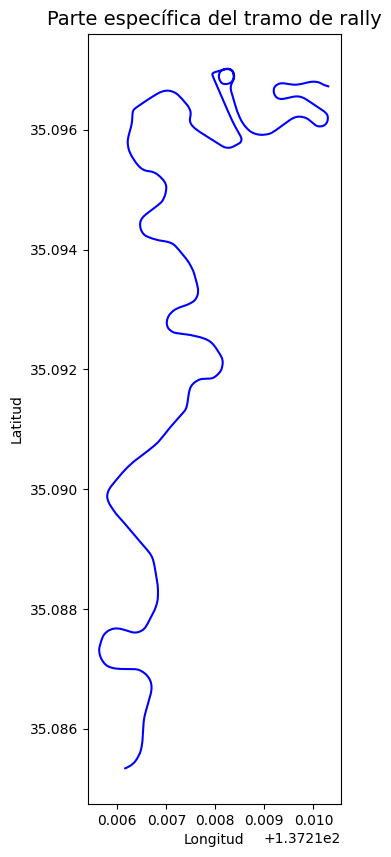

In [41]:
# Cargar el archivo KML con geopandas
gdf = gpd.read_file("FORUM8 Rally Japan 2024.kml", driver='KML', layer='Shakedown')



# Crear una figura y un eje con matplotlib
fig, ax = plt.subplots(figsize=(10, 10))

# Plotea las geometrías usando geopandas
gdf.plot(ax=ax, color='blue', edgecolor='black')

# Personalizar el gráfico
ax.set_title("Parte específica del tramo de rally", fontsize=14)
ax.set_xlabel("Longitud", fontsize=10)
ax.set_ylabel("Latitud", fontsize=10)
plt.show()

In [48]:
# Verifica el CRS original
print("CRS original:", gdf.crs)

# Transformar a un CRS proyectado (por ejemplo, UTM o Web Mercator EPSG:3857)
gdf_projected = gdf.to_crs(epsg=3099)

# Calcular la longitud de cada tramo en metros
gdf_projected['length_m'] = gdf_projected.length

# Convertir la longitud a kilómetros
gdf_projected['length_km'] = gdf_projected['length_m'] / 1000

# Mostrar las longitudes en kilómetros
print(f"{gdf_projected['length_km'][0]:.2f} Kms")  # 'name' es un ejemplo de columna, cámbialo según tus datos

CRS original: EPSG:4326
2.79 Kms


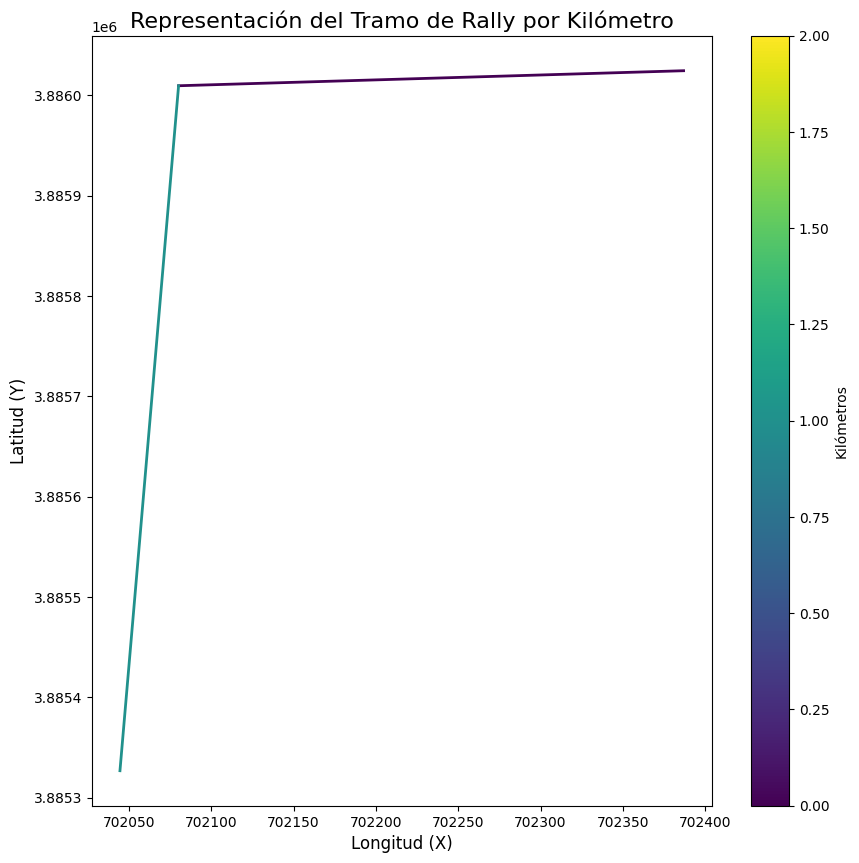

In [50]:
from shapely.geometry import LineString


# Inicializar la figura para dibujar
fig, ax = plt.subplots(figsize=(10, 10))

# Crear una lista de colores (puedes personalizar los colores según lo que desees)
# Usamos un mapa de colores para asignar un color a cada kilómetro
cmap = plt.cm.get_cmap('viridis')  # O puedes usar 'plasma', 'inferno', 'jet', etc.

# Iterar sobre las geometrías y dividirlas en segmentos de 1 kilómetro
for geom in gdf_projected.geometry:
    if geom.geom_type == 'LineString':  # Si la geometría es una línea
        # Calcular la longitud total del tramo en metros
        total_length = geom.length
        
        # Dividir la línea en segmentos de 1 km
        num_segments = int(total_length // 1000)  # Número de segmentos de 1 km

        # Calcular los puntos de segmentación
        for i in range(num_segments):
            start_dist = i * 1000  # Distancia de inicio de cada segmento (en metros)
            end_dist = (i + 1) * 1000  # Distancia final de cada segmento (en metros)

            # Usar el método `interpolate` para dividir la línea
            start_point = geom.interpolate(start_dist)  # Punto de inicio del segmento
            end_point = geom.interpolate(end_dist)  # Punto de final del segmento

            # Crear una nueva línea para el segmento
            segment = LineString([start_point, end_point])

            # Asignar un color basado en el índice del segmento
            color = cmap(i / num_segments)  # Normalizar el índice a 0-1 para el mapa de colores

            # Dibujar el segmento en el gráfico
            x, y = segment.xy  # Obtener las coordenadas del segmento
            ax.plot(x, y, color=color, linewidth=2)

# Añadir una barra de colores para mostrar el mapa de colores
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_segments))
sm.set_array([])  # Esto es necesario para el ScalarMappable
fig.colorbar(sm, ax=ax, label='Kilómetros')

# Añadir título y etiquetas
ax.set_title("Representación del Tramo de Rally por Kilómetro", fontsize=16)
ax.set_xlabel("Longitud (X)", fontsize=12)
ax.set_ylabel("Latitud (Y)", fontsize=12)

# Mostrar el mapa
plt.show()

In [51]:
gdf_projected.geometry

0    LINESTRING Z (702386.936 3886024.699 0, 702382...
Name: geometry, dtype: geometry